### Step 1. Dataset Load & Exploration


### 1. Import Libraries

In [147]:
# import nltk
# import os

# # Set the NLTK data path explicitly
# nltk.data.path.append(r"C:\Users\Hp\AppData\Roaming\nltk_data")

# # Re-download NLTK resources
# try:
#     nltk.download('punkt_tab', download_dir=r"C:\Users\Hp\AppData\Roaming\nltk_data")
#     nltk.download('stopwords', download_dir=r"C:\Users\Hp\AppData\Roaming\nltk_data")
#     nltk.download('wordnet', download_dir=r"C:\Users\Hp\AppData\Roaming\nltk_data")
#     print("NLTK resources downloaded successfully.")
# except Exception as e:
#     print(f"Error downloading NLTK resources: {e}")

In [148]:

# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# # Set NLTK data path
# nltk.data.path.append(r"C:\Users\Hp\AppData\Roaming\nltk_data")

# # Test NLTK components
# try:
#     print("Testing word_tokenize:", word_tokenize("This is a test sentence."))
#     print("Testing stopwords:", stopwords.words('english')[:5])
#     print("Testing lemmatizer:", WordNetLemmatizer().lemmatize("running"))
# except Exception as e:
#     print(f"Error testing NLTK components: {e}")

In [167]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [150]:
# Set NLTK data path
nltk.data.path = [r"C:\Users\Hp\AppData\Roaming\nltk_data"]

In [151]:
try:
    nltk.download('punkt_tab', download_dir=r"C:\Users\Hp\AppData\Roaming\nltk_data", quiet=True)
    nltk.download('stopwords', download_dir=r"C:\Users\Hp\AppData\Roaming\nltk_data", quiet=True)
    nltk.download('wordnet', download_dir=r"C:\Users\Hp\AppData\Roaming\nltk_data", quiet=True)
    print("NLTK resources verified.")
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

NLTK resources verified.


### 2. Load Both CSV Files

In [152]:
df_fake = pd.read_csv("fake.csv")
df_real = pd.read_csv("true.csv")

### 3. Add a label Column

In [153]:
df_fake["label"] = 0 
df_real["label"] = 1

### 4. Merge Both DataFrames

In [154]:
df = pd.concat( [df_fake , df_real ] , ignore_index= True)

### Explore

In [155]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [157]:
df.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Step 2. Preprocessing 

### 1. Handling Missing Values

In [158]:
df.isnull().sum()   # no missing values founds

title      0
text       0
subject    0
date       0
label      0
dtype: int64

### 2. Identify Outliers and remove

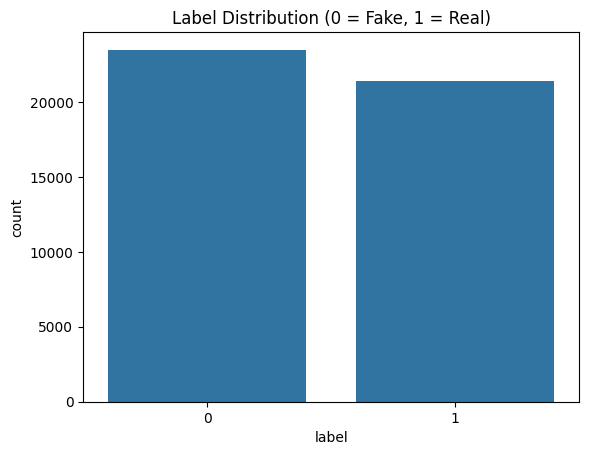

In [159]:
sns.countplot(x='label', data=df)
plt.title('Label Distribution (0 = Fake, 1 = Real)')
plt.show()


# We skip scaling because text features like title, text, and subject 
# are not numeric — they’ll be handled using NLP.

### Step 3: Combine Text Columns

In [160]:

df["content"] = df["title"].astype(str) + "  " + df["subject"].astype(str) + "  " + df["text"].astype(str)

###  Step 4: NLP Preprocessing

In [161]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [162]:
df.head()

,title,text,subject,date,label,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...


In [163]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


In [164]:
df["content"].head()

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
Name: content, dtype: object

In [ ]:

# Apply preprocessing
print("Starting text preprocessing...")
df['processed_content'] = df['content'].apply(preprocess_text)


Starting text preprocessing...


0    donald trump sends embarrassing new year eve m...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama name coded website i...
4    pope francis called donald trump christmas spe...
Name: processed_content, dtype: object

In [166]:
df['processed_content'].head()

0    donald trump sends embarrassing new year eve m...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama name coded website i...
4    pope francis called donald trump christmas spe...
Name: processed_content, dtype: object

### Step 5: Feature Extraction (TF-IDF)

In [ ]:

print("Starting TF-IDF vectorization...")
# Initialize TF-IDF Vectorizer
# You can experiment with parameters like max_features, ngram_range, etc.
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting features to 5000 for efficiency

# Fit and transform the 'processed_content' column
x = tfidf_vectorizer.fit_transform(df['processed_content'])
y = df['label'] # Our target variable

print("TF-IDF vectorization complete. Shape of X:", x.shape)


Starting TF-IDF vectorization...
TF-IDF vectorization complete. Shape of X: (44898, 5000)


### Step 6: Split Data

In [176]:
# Split data into training and testing sets

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.2 , random_state=42)